In [0]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('/content/gdrive/My Drive/Data_Science')

In [4]:
df = pd.read_csv('loan.csv',
                low_memory = False)


df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,...,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,...,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0.0,Apr-2011,0.0,NaN,NaN,8.0,0.0,4599,19.1,13.0,w,4787.21,4787.21,353.89,353.89,...,0.0,0.0,136927.0,11749.0,13800.0,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,985xx,WA,16.74,0.0,Feb-2006,0.0,NaN,NaN,10.0,0.0,5468,78.1,13.0,w,3831.93,3831.93,286.71,286.71,...,0.0,0.0,385183.0,36151.0,5000.0,44984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,212xx,MD,26.35,0.0,Dec-2000,0.0,NaN,NaN,12.0,0.0,829,3.6,26.0,w,29339.02,29339.02,1423.21,1423.21,...,0.0,0.0,157548.0,29674.0,9300.0,32332.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df.shape)
df.info()

(2260668, 145)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [6]:
df.isnull().sum().sort_values(ascending = False)

id                                            2260668
member_id                                     2260668
url                                           2260668
orig_projected_additional_accrued_interest    2252242
hardship_start_date                           2250055
hardship_end_date                             2250055
payment_plan_start_date                       2250055
hardship_length                               2250055
hardship_dpd                                  2250055
hardship_loan_status                          2250055
hardship_payoff_balance_amount                2250055
deferral_term                                 2250055
hardship_last_payment_amount                  2250055
hardship_status                               2250055
hardship_reason                               2250055
hardship_type                                 2250055
hardship_amount                               2250055
settlement_percentage                         2227612
settlement_term             

There are multiple columns where every value is null so those columns will be removed immediately. There seem to be about 100,000 rows that have values related to hardship and the rest of the loans have nothing in regards to hardships which makes sense. 

The amount of null values will require some aggressive cleaning. Luckily there is still a large amount of data even after cleaning

In [0]:
#Removing the columns with only null values
df = df.drop(['id', 'member_id', 'url'], axis = 1)


In [8]:
df.shape

(2260668, 142)

Text(0.5, 1.0, 'Amount applied for by borrower')

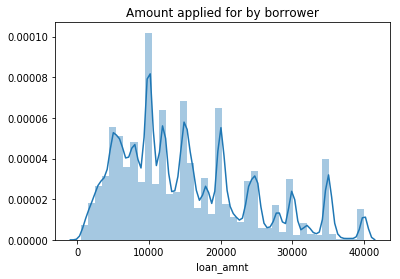

In [9]:
#Seeing the distribution of loans across different amounts 
sns.distplot(df['loan_amnt'], bins = 40).set_title('Amount applied for by borrower')


In [10]:
#Inspecting the column to see how it represents time
df['issue_d'].head()

0    Dec-2018
1    Dec-2018
2    Dec-2018
3    Dec-2018
4    Dec-2018
Name: issue_d, dtype: object

In [0]:
#Creating a pandas datetime column with the issue year
df['issue_year'] = pd.to_datetime(df['issue_d']).dt.year

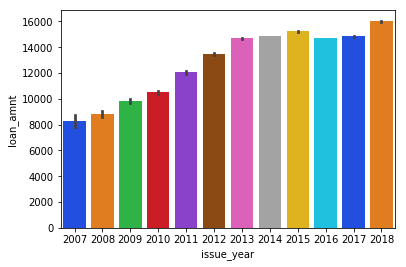

In [12]:
#Average value for loans issues per year
sns.barplot('issue_year', 'loan_amnt', data = df, palette = 'bright')

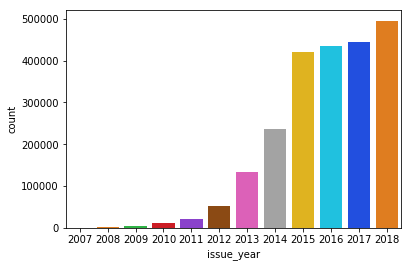

In [13]:
#Seeing how many loans were issued each year
sns.countplot('issue_year', data = df, palette = 'bright')


Wow that is some really impressive growth.  Assuming of course that this dataset is representative of all of Lending Club's loans. I will do a count of how many occurances of each year there are. 

In [14]:
#Looking at the numbers on the above graph
Counter(df['issue_year'])


Counter({2007: 603,
         2008: 2393,
         2009: 5281,
         2010: 12537,
         2011: 21721,
         2012: 53367,
         2013: 134814,
         2014: 235629,
         2015: 421095,
         2016: 434407,
         2017: 443579,
         2018: 495242})

In [15]:
#Seeing how many different statuses there are
df['loan_status'].unique()

array(['Current', 'Fully Paid', 'Late (31-120 days)', 'In Grace Period',
       'Charged Off', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [16]:
#Seeing how many loans are in each status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

There are multiple categories that reasonably count as bad loans.  Charged Off a loan taken off the books due to no reasonable expectation of payment. https://help.lendingclub.com/hc/en-us/articles/216127747-What-is-the-difference-between-a-loan-that-is-in-default-and-a-loan-that-has-been-charged-off-

The categories I will consider bad are Charged Off, Late(both 16-30 days and 31-120 days), default and "Does not meet the credit policy. Status:Charged Off"(I still don't know what credit policy the loan does not meet but I know enough to know any loan in this category is bad).

In [17]:
#Creating a new column to represent whether or not a status is good
bad_statuses = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)',
               'Does not meet the credit policy. Status:Charged Off', 'Default']

df['good_loan'] = 1

df.loc[df['loan_status'].isin(bad_statuses), 'good_loan'] = 0
df['good_loan'].head()

0    1
1    1
2    1
3    1
4    1
Name: good_loan, dtype: int64

In [18]:
#Seeing how many loans are good or bad
Counter(df['good_loan'])

Counter({0: 288081, 1: 1972587})

In [19]:
#Checking the ratio of good to bad loans
print(Counter(df['good_loan'])[0]/Counter(df['good_loan'])[1])
print("The current percentage of bad loans is {}%".format((Counter(df['good_loan'])[0]/Counter(df['good_loan'])[1]) * 100))

0.14604222779527595
The current percentage of bad loans is 14.604222779527595%


I do not know if this makes Lending Club loans better or worse then the competition because I have no idea what results the competition is getting but at least there is a number to work with.  

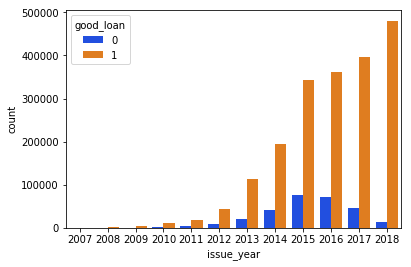

In [20]:
#Making a count plot of good to bad loans by year
sns.countplot('issue_year',hue = 'good_loan', data = df, palette = 'bright',)



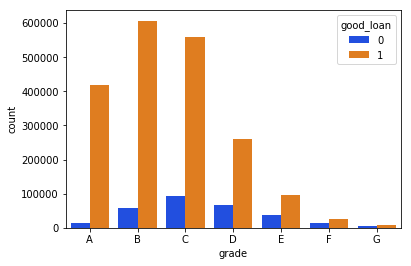

In [21]:
#Good to bad loans by grade
sns.countplot('grade',hue = 'good_loan', data = df, palette = 'bright',
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])



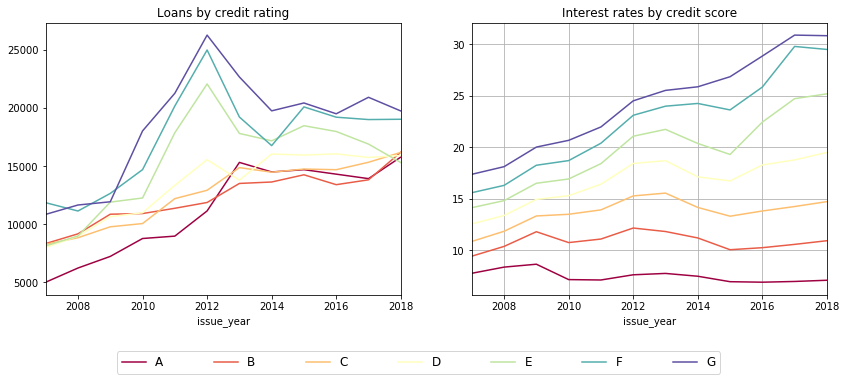

In [22]:
#Looking at loans by credit score
f, ((ax1, ax2)) = plt.subplots(1,2)

cmap = plt.cm.Spectral

groupby_credit_rating = df.groupby(['issue_year', 'grade']).loan_amnt.mean()
groupby_credit_rating.unstack().plot(legend = False, ax = ax1,figsize=(14,5), colormap = cmap)
ax1.set_title("Loans by credit rating")
    

interest_credit_rating = df.groupby(['issue_year', 'grade']).int_rate.mean()
interest_credit_rating.unstack().plot(legend = False, ax = ax2, figsize=(14,5),colormap = cmap)
ax2.set_title("Interest rates by credit score")
plt.grid(True)  

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

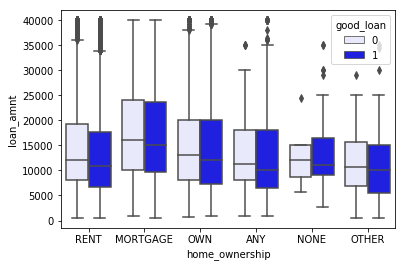

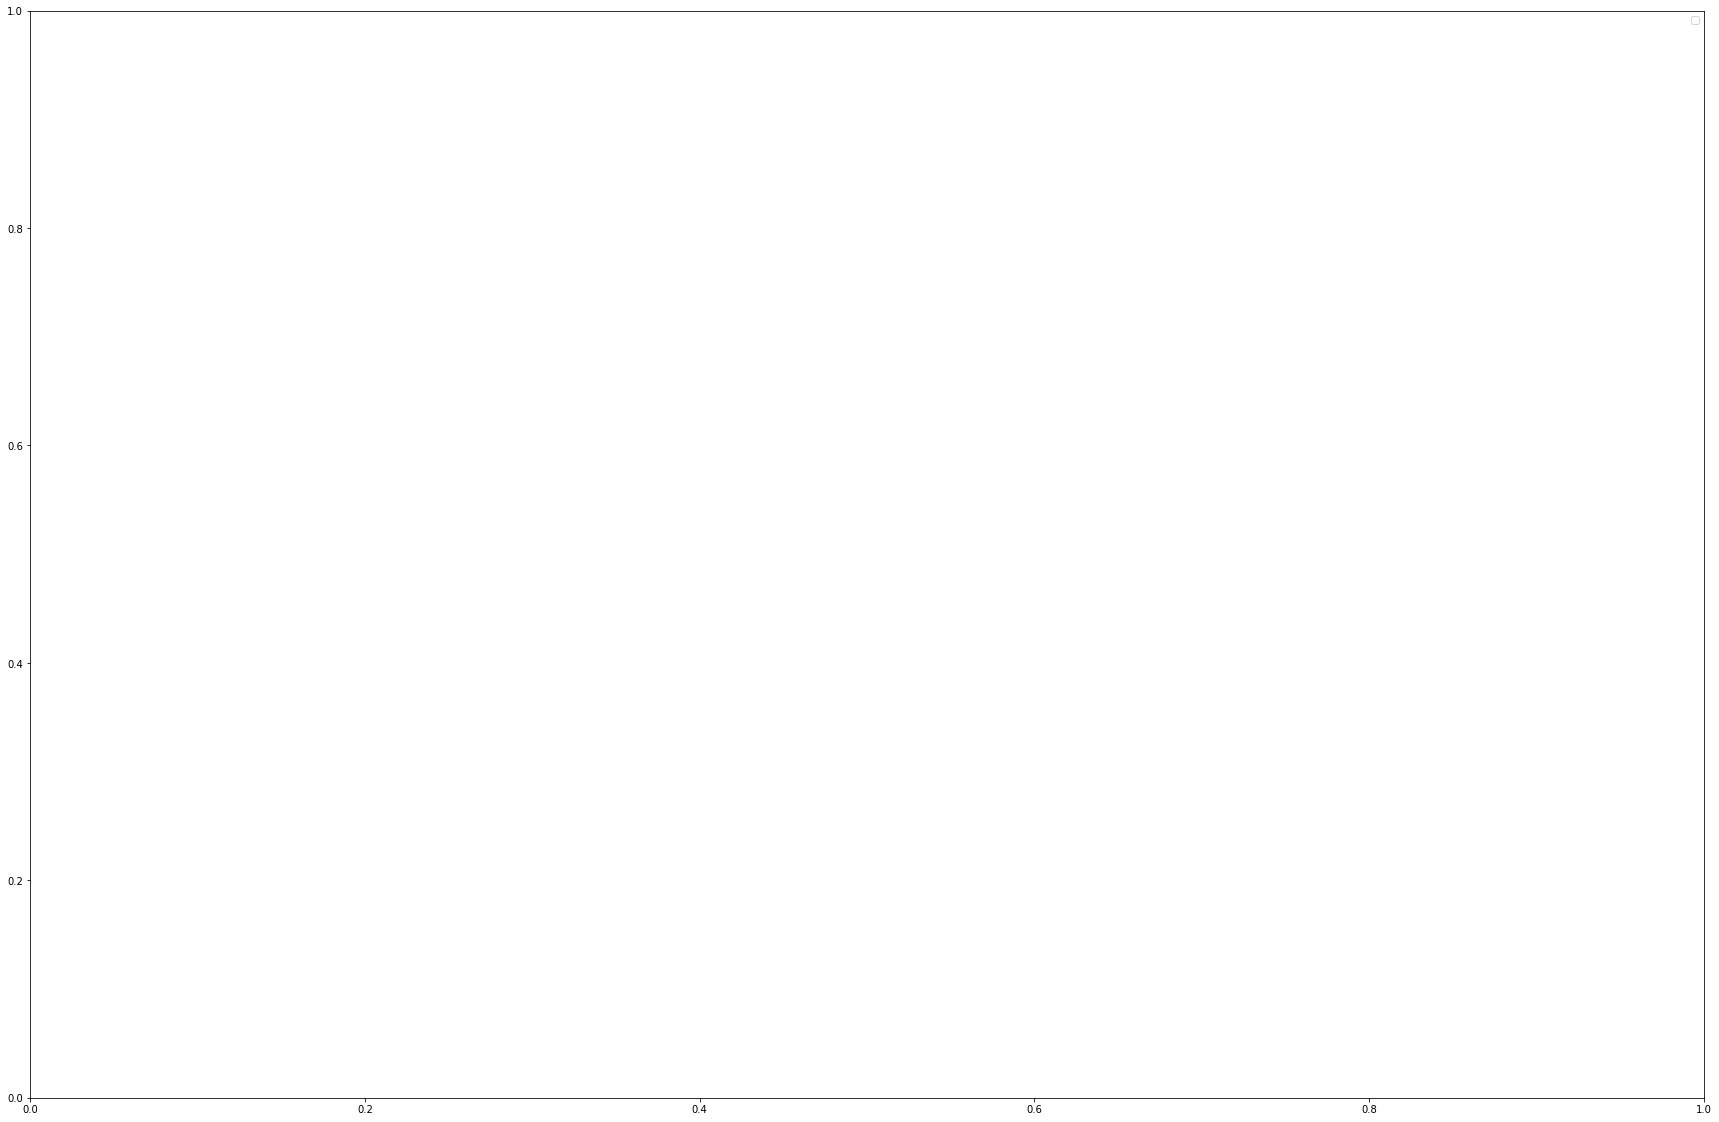

In [23]:
ownership_boxplot = sns.boxplot(x = 'home_ownership', y ='loan_amnt', 
                     hue = 'good_loan', data = df, color = 'b')
plt.figure(figsize = (30,20))
plt.legend(['Bad', 'Good'])
plt.show()

Next is feature selection. Here I am going to start looking to see what features have higher correlations and clean up the data more before the modeling starts. 

In [24]:
corr = df.corr().loc[:, 'good_loan'].sort_values()

print(corr)

recoveries                                   -0.490569
collection_recovery_fee                      -0.465110
hardship_dpd                                 -0.232085
int_rate                                     -0.206668
total_rec_late_fee                           -0.131513
sec_app_inq_last_6mths                       -0.097421
acc_open_past_24mths                         -0.094552
inq_last_6mths                               -0.086853
num_tl_op_past_12m                           -0.084050
hardship_amount                              -0.083270
open_rv_24m                                  -0.079876
percent_bc_gt_75                             -0.074229
inq_last_12m                                 -0.074013
bc_util                                      -0.071613
orig_projected_additional_accrued_interest   -0.070585
all_util                                     -0.069046
open_acc_6m                                  -0.067543
open_rv_12m                                  -0.065152
revol_util

In [25]:
#Removing all columns that are objects
df.columns[df.columns.str.isnumeric()]
df = df.select_dtypes(exclude = ['object'])  
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 108 entries, loan_amnt to good_loan
dtypes: float64(102), int64(6)
memory usage: 1.8 GB


In [0]:
#Making an array out of the columns sorted by amount of NA values
na_array = df.isna().sum().sort_values(ascending = False)

In [27]:
#Using the above array as a list to then remove the columns with the most NA values
na_list = na_array.index

df = df.drop(na_list[:42], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 66 columns):
loan_amnt                     int64
funded_amnt                   int64
funded_amnt_inv               float64
int_rate                      float64
installment                   float64
annual_inc                    float64
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     int64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt                   float64
total_pymnt_inv               float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
last_pymnt_amnt    

In [28]:
df.isna().sum().sort_values(ascending = False)

num_tl_120dpd_2m              153657
mo_sin_old_il_acct            139071
bc_util                        76071
percent_bc_gt_75               75379
bc_open_to_buy                 74935
mths_since_recent_bc           73412
pct_tl_nvr_dlq                 70431
avg_cur_bal                    70346
mo_sin_old_rev_tl_op           70277
mo_sin_rcnt_rev_tl_op          70277
num_rev_accts                  70277
total_rev_hi_lim               70276
num_bc_tl                      70276
tot_cur_bal                    70276
tot_coll_amt                   70276
num_accts_ever_120_pd          70276
num_actv_bc_tl                 70276
num_actv_rev_tl                70276
mo_sin_rcnt_tl                 70276
num_il_tl                      70276
tot_hi_cred_lim                70276
num_op_rev_tl                  70276
num_rev_tl_bal_gt_0            70276
num_tl_30dpd                   70276
total_il_high_credit_limit     70276
num_tl_90g_dpd_24m             70276
num_tl_op_past_12m             70276
n

In [29]:
df = df.dropna()
df.info()
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2013799 entries, 0 to 2260666
Data columns (total 66 columns):
loan_amnt                     int64
funded_amnt                   int64
funded_amnt_inv               float64
int_rate                      float64
installment                   float64
annual_inc                    float64
dti                           float64
delinq_2yrs                   float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     int64
revol_util                    float64
total_acc                     float64
out_prncp                     float64
out_prncp_inv                 float64
total_pymnt                   float64
total_pymnt_inv               float64
total_rec_prncp               float64
total_rec_int                 float64
total_rec_late_fee            float64
recoveries                    float64
collection_recovery_fee       float64
last_pymnt_amnt    

Due to how imbalanced the target variable is I am going to do a random undersampling of the target to create more balanced training data. When I previously attempted oversampling I created a dataframe with over 3 million columns.  This is well beyond what my computer is able to currently handle and I was unable to make it work well with Google Colab's free service.

In [30]:
#Undersampling for balance
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [31]:
from sklearn.model_selection import train_test_split
X = df.drop(['good_loan'], axis = 1)
y = df['good_loan']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2 )

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(X_resampled.shape)
print(y_resampled.shape)


(401242, 65)
(401242,)


In [32]:
print(y.shape)

(2013799,)


In [0]:
#Removing some variables to save memory
del df
del X

## Modeling
Here is where the model fitting begins

In [0]:
#The modeling starts here

from sklearn.ensemble import RandomForestClassifier

In [35]:

rfc = RandomForestClassifier(n_estimators = 100, n_jobs = 5)

rfc.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
y_pred = rfc.predict(X_test)

In [37]:
%timeit
from sklearn import metrics
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("Misclassification Rate: " + 
      str(((conf_matrix[0][1] + conf_matrix[1][0]) / conf_matrix.sum())*100 ) +'%')
print("True positive rate: " + 
      str((conf_matrix[1][1] / (conf_matrix[1].sum()))*100 ) +'%')
print("False positive rate: " +
     str((conf_matrix[0][1] / (conf_matrix[0].sum()))*100 ) +'%')
print("True negative rate: "+
     str((conf_matrix[0][0] / (conf_matrix[0].sum()))*100 ) +'%')

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

[[ 46222   3555]
 [  3010 349973]]
Misclassification Rate: 1.6300029794418511%
True positive rate: 99.14726771544238%
False positive rate: 7.1418526628764285%
True negative rate: 92.85814733712357%
Accuracy: 0.9836999702055815


In [40]:
from sklearn.linear_model import Perceptron 

perceptron = Perceptron()

perceptron.fit(X_resampled, y_resampled)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
print('Score: ' + str(perceptron.score(X_resampled, y_resampled)))

Score: 0.8818169583443408


In [0]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     50005
           1       0.99      0.99      0.99    352755

    accuracy                           0.98    402760
   macro avg       0.96      0.96      0.96    402760
weighted avg       0.98      0.98      0.98    402760



In [0]:
#Making a second rfc model



rfc2 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_depth = 80,min_samples_leaf = 4)

rfc2.fit(X_resampled, y_resampled)
rfc2_y_pred = rfc2.predict(X_test)


In [0]:
print(metrics.accuracy_score(y_test, rfc2_y_pred))
print(metrics.classification_report(y_test, rfc2_y_pred))
print(confusion_matrix(y_test, rfc2_y_pred))

0.9837297646240938
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     49790
           1       0.99      0.99      0.99    352970

    accuracy                           0.98    402760
   macro avg       0.97      0.96      0.96    402760
weighted avg       0.98      0.98      0.98    402760

[[ 46043   3747]
 [  2806 350164]]


Very similiar results between the two random forest models. But the first one had fewer type 1 errors. 

## Gradient Boosted Models
Here are some gradient boosted models. The for loop two cells below tested different models with different learning rates. 

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc

In [0]:

learning_rates = [.05, .1, .25, .5, .75, 1]

for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators = 20, learning_rate = learning_rate, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (test): {0:.3f}".format(gb.score(X_test, y_test)))
    print()
#Best score on the test set is with learning rate .75


Learning rate:  0.05
Accuracy score (training): 0.951
Accuracy score (test): 0.950

Learning rate:  0.1
Accuracy score (training): 0.952
Accuracy score (test): 0.952

Learning rate:  0.25
Accuracy score (training): 0.979
Accuracy score (test): 0.979

Learning rate:  0.5
Accuracy score (training): 0.985
Accuracy score (test): 0.985

Learning rate:  0.75
Accuracy score (training): 0.986
Accuracy score (test): 0.985

Learning rate:  1
Accuracy score (training): 0.986
Accuracy score (test): 0.986



The best test scores come from a learning rate of 1 and .75

In [0]:
gb = GradientBoostingClassifier(n_estimators = 20, learning_rate = .75, random_state = 0)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.75, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
from sklearn.metrics import accuracy_score
gb_predictions = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_predictions)
print("Accuracy: " + str(gb_accuracy * 100) + "%")

Accuracy: 98.54330122157116%


In [0]:
gb_conf_matrix = confusion_matrix(y_test, gb_predictions)
print("Misclassification Rate: " + 
      str(((gb_conf_matrix[0][1] + gb_conf_matrix[1][0]) / gb_conf_matrix.sum())*100 ) +'%')
print("True positive rate: " + 
      str((gb_conf_matrix[1][1] / (gb_conf_matrix[1].sum()))*100 ) +'%')
print("False positive rate: " +
     str((gb_conf_matrix[0][1] / (gb_conf_matrix[0].sum()))*100 ) +'%')
print("True negative rate: "+
     str((gb_conf_matrix[0][0] / (gb_conf_matrix[0].sum()))*100 ) +'%')
print(gb_conf_matrix)

Misclassification Rate: 1.456698778428841%
True positive rate: 99.91330707992181%
False positive rate: 11.16890941956216%
True negative rate: 88.83109058043785%
[[ 44229   5561]
 [   306 352664]]


In [0]:
print(metrics.classification_report(y_test, gb_predictions))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     49790
           1       0.98      1.00      0.99    352970

    accuracy                           0.99    402760
   macro avg       0.99      0.94      0.96    402760
weighted avg       0.99      0.99      0.99    402760



Random forest still looks the best.  The recall is where this model is noticably worse then the first random forest. For this project recall is the most important result. 


In [0]:
from xgboost import XGBClassifier

In [0]:
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
XGB_y_pred = XGB_model.predict(X_test)
XGB_predictions = [round(value) for value in XGB_y_pred]

accuracy = accuracy_score(y_test, XGB_predictions)
print("Accuracy: " + str(accuracy * 100) + "%")

Accuracy: 98.37769391200715%


In [0]:
XGB_conf_matrix = confusion_matrix(y_test, XGB_y_pred)
print("Misclassification Rate: " + 
      str(((XGB_conf_matrix[0][1] + XGB_conf_matrix[1][0]) / XGB_conf_matrix.sum())*100 ) +'%')
print("True positive rate: " + 
      str((XGB_conf_matrix[1][1] / (XGB_conf_matrix[1].sum()))*100 ) +'%')
print("False positive rate: " +
     str((XGB_conf_matrix[0][1] / (XGB_conf_matrix[0].sum()))*100 ) +'%')
print("True negative rate: "+
     str((XGB_conf_matrix[0][0] / (XGB_conf_matrix[0].sum()))*100 ) +'%')
print(XGB_conf_matrix)

Misclassification Rate: 1.6223060879928493%
True positive rate: 99.999150069411%
False positive rate: 13.117091785499097%
True negative rate: 86.88290821450092%
[[ 43259   6531]
 [     3 352967]]


In [0]:
print(metrics.classification_report(y_test, XGB_predictions))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93     49790
           1       0.98      1.00      0.99    352970

    accuracy                           0.98    402760
   macro avg       0.99      0.93      0.96    402760
weighted avg       0.98      0.98      0.98    402760



Even worse recall and false positive rate then the other models. Second worst model of all the ones tried so far with the worst being the Gaussian. 

In [0]:
from sklearn.naive_bayes import GaussianNB

gaussian_model = GaussianNB()

gaussian_model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
gaussian_y_pred = gaussian_model.predict(X_test)
gaussian_accuracy = accuracy_score(y_test, gaussian_y_pred)
print("Accuracy: " + str(gaussian_accuracy * 100) + "%")

Accuracy: 94.7164564504916%


In [0]:
print(confusion_matrix(y_test, gaussian_y_pred))
print(metrics.classification_report(y_test, gaussian_y_pred))

[[ 29630  20160]
 [  1120 351850]]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     49790
           1       0.95      1.00      0.97    352970

    accuracy                           0.95    402760
   macro avg       0.95      0.80      0.85    402760
weighted avg       0.95      0.95      0.94    402760



Wow that recall is bad. 

The Gaussian model does not work well. Perhaps it could be optimized but I am getting far better results far faster with other models.  Random forest is still in the lead. 